<h1>Capstone Project - Data Analysis</h1>

<h2> Problem Description: What is the best location for a new Asian restaurant in Toronto?</h2>


<b>Business Problem:</b> We want to find the best location for an Asian restaurant in Toronto. The best location is where there are  many potential customers and there should not be another Asian restaurant closeby. We cannot get a direct handle on the number of customers, because they are not necessarily the residence of a certain neighborhood, but can also people who are in the neighborhood for work. So, we will get a handle on potential customers by looking at the total number of restaurants in a certain neighborhood and pick a location where Asian restaurants are underrepresented. <br>

<b>Who could be interested in this analysis?</b> Any business that wants to open a restaurant in Toronto and needs to pick a location.

<br>

<h3>A description of the data and how it will be used to solve the problem. </h3> <br>

We will try to get all restaurants in Toronto and create a model of all non-asian restaurants. We do the same for Asian restaurants. Our metric for the decision will be the neighborhood with the lowest ratio of "Asia restaurants" vs "Total number of restaurants". In the following we will use location data to get this information.<br> <br>

<h2> Setting up everything and creating a standard Foursquare call </h2>

In [2]:
!pip install folium -q
!conda install -c conda-forge geopy --yes -q

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geop

In [3]:
!conda install -c conda-forge folium=0.5.0 --yes -q

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

    altair:  4.1.0-py_1 conda-forge
    branca:  0.4.0-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge

Preparing transaction: ...working... done
Verifying transaction

In [4]:
!pip install shapely -q
!pip install pyproj -q

In [5]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

import shapely.geometry

import pyproj

import math

import pickle

In [47]:
#Foursquare tutorial: https://medium.com/@aboutiana/a-brief-guide-to-using-foursquare-api-with-a-hands-on-example-on-python-6fc4d5451203
print('REMOVED because it contained Foursquare credentials')


#Hint: https://developer.foursquare.com/docs/build-with-foursquare/categories/ You can find the categories for Foursquare here.

REMOVED because it contained Foursquare credentials


<h2> Producing a search grid for Toronto </h2>

In [48]:
#Some coordinates in Totonto, these will be the center of our grid
MAP_COORDINATES = (43.6970,-79.347015)
  

corner1 = (43.749326, -79.638862)
corner2 = (43.546948, -79.514429)    
corner3 = (43.778842, -79.122462)
corner4 = (43.839164, -79.233500)
corners =[corner1,corner2,corner3,corner4]

# create empty map zoomed in on Toronto
map_toronto = folium.Map(location=MAP_COORDINATES, zoom_start=11)
folium.Marker(location = [MAP_COORDINATES[0],MAP_COORDINATES[1]]).add_to(map_toronto)
folium.Marker(location = [corner1[0],corner1[1]]).add_to(map_toronto)
folium.Marker(location = [corner2[0],corner2[1]]).add_to(map_toronto)
folium.Marker(location = [corner3[0],corner3[1]]).add_to(map_toronto)
folium.Marker(location = [corner4[0],corner4[1]]).add_to(map_toronto)


display(map_toronto)



In [11]:
#This is from the Coursera example, but improved and adjusted. I am not going to reinvent the wheel here ;)

def lonlat_to_xy(lat, lon): # I fouind it weird to have lat and lon swapped, I changed it.
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[1], lonlat[0]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)


#This was not part of the example. Take the equation for a line and check whether a point is above or beelow
def point_outside_of_four_corner_grid(lat,lon,corners): #We treat the coordinates as if they are kartesian, this is good enough.
    is_inside = True
    if (lon < ((corners[1][1]-corners[0][1])/(corners[1][0]-corners[0][0])*(lat-corners[1][0])+corners[1][1])): #01
        is_inside = False
    if (lon > ((corners[2][1]-corners[1][1])/(corners[2][0]-corners[1][0])*(lat-corners[2][0])+corners[2][1])): #12
        is_inside = False
    if (lon > ((corners[3][1]-corners[2][1])/(corners[3][0]-corners[2][0])*(lat-corners[3][0])+corners[3][1])): #23
        is_inside = False        
    if (lon < ((corners[0][1]-corners[3][1])/(corners[0][0]-corners[3][0])*(lat-corners[0][0])+corners[0][1])): #30
        is_inside = False  
    return is_inside

toronto_center_x, toronto_center_y = lonlat_to_xy(MAP_COORDINATES[0], MAP_COORDINATES[1]) # City center in Cartesian coordinates

grid_radius   = 50000 # in meters
distance_of_centers = 2000 # in meters
iterations = 100 #int(grid_radius/distance_of_centers*20)#100 #21*2

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = toronto_center_x - grid_radius
x_step = distance_of_centers
y_min = toronto_center_y - grid_radius - (int(iterations/k)*k*distance_of_centers - distance_of_centers)/2
y_step = distance_of_centers  * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
count = 0
for i in range(0, int(iterations/k)):
    y = y_min + i * y_step
    x_offset = distance_of_centers/2 if i%2==0 else 0
    for j in range(0, iterations):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(toronto_center_x, toronto_center_y, x, y)
        lat, lon = xy_to_lonlat(x, y)
        #print(lon,corners[0][1],point_outside_of_four_corner_grid(lat,lon,corners))
        #if (distance_from_center <= grid_radius+1) and
        if point_outside_of_four_corner_grid(lat,lon,corners):
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)
            count = count + 1

print("Number of circles: ",count)            
yard_to_meter = 0.9144            
            
map_toronto = folium.Map(location=MAP_COORDINATES, zoom_start=11)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=distance_of_centers/2/2*math.sqrt(3)*yard_to_meter, color='blue', fill=False).add_to(map_toronto)
    #folium.Marker([lat, lon]).add_to(map_berlin)

folium.Marker(location = [corner1[0],corner1[1]]).add_to(map_toronto)
folium.Marker(location = [corner2[0],corner2[1]]).add_to(map_toronto)
folium.Marker(location = [corner3[0],corner3[1]]).add_to(map_toronto)
folium.Marker(location = [corner4[0],corner4[1]]).add_to(map_toronto)
map_toronto

Number of circles:  379


In [12]:
print(distance_of_centers/2/2*math.sqrt(3))

866.0254037844386


Let's create our initial pandas dataframe:

In [13]:
df_locations = pd.DataFrame({#'Address': addresses,
                           'Latitude': latitudes,
                           'Longitude': longitudes,
                           'X': xs,
                           'Y': ys,
                           'Distance from center': distances_from_center #not really needed, but might be handy.
                           })

df_locations.to_pickle('./locations.pkl') 

df_locations.head()

,Latitude,Longitude,X,Y,Distance from center
0,43.776224,-79.136443,-5.294075e+06,1.047690e+07,27499.941483
1,43.768875,-79.150424,-5.295075e+06,1.047863e+07,25524.611700
2,43.781324,-79.152220,-5.293075e+06,1.047863e+07,26296.497912
3,43.793775,-79.154017,-5.291075e+06,1.047863e+07,27193.855969
4,43.761523,-79.164399,-5.296075e+06,1.048036e+07,23553.446102


<h3> Foursquare </h3>

Now we going to get the number of restaurants and the number of asian restaurants per circle. 
We will divide the two but ignore the circles with zero restaurants. 
https://developer.foursquare.com/docs/resources/categories

In contrast to the example on the Coursera website, we will include all kinds of food related venues like coffe shops, pizza places, bakeries etc., because we want to get a proxy for the amount of people pass our potential asian restaurant.


In [14]:
food_category = '4d4b7105d754a06374d81259' 
asian_restaurant_category = '4bf58dd8d48988d142941735'

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
        print('Exception!')
    return venues


def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    #address = address.replace(', Deutschland', '')
    #address = address.replace(', Germany', '')
    return address

def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        #if 'fast food' in category_name:
        #    restaurant = False
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific


def get_restaurants(lats, lons,foursquare_client_id, foursquare_client_secret):
    restaurants = {}
    asian_restaurants = {}
    location_restaurants = []
   
    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        #print(str(lat), str(lon), food_category, foursquare_client_id, foursquare_client_secret, '870', '100')
        # Using radius=870 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(str(lat), str(lon), food_category, foursquare_client_id, foursquare_client_secret, radius='870', limit='100')
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_asian = is_restaurant(venue_categories, specific_filter=asian_restaurant_category)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_asian, x, y)
                if venue_distance<=866:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_asian:
                    asian_restaurants[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print(' .', end='')
    print(' done.')
    return restaurants, asian_restaurants, location_restaurants

In [15]:
# Try to load from local file system in case we did this before
restaurants = {}
asian_restaurants = {}
location_restaurants = []
loaded = False
try:
    with open('restaurants_866.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('asian_restaurants_866.pkl', 'rb') as f:
        asian_restaurants = pickle.load(f)
    with open('location_restaurants_866.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass


# If load failed use the Foursquare API to get the data
if not loaded:
    restaurants, asian_restaurants, location_restaurants = get_restaurants(latitudes, longitudes,CLIENT_ID, CLIENT_SECRET)
    
    # Let's persists this in local file system
    with open('restaurants_866.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('asian_restaurants_866.pkl', 'wb') as f:
        pickle.dump(asian_restaurants, f)
    with open('location_restaurants_866.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)



Obtaining venues around candidate locations: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Exception!
 . .Exception!
 . . .Exception!
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Exception!
 . .Exception!
 . . . . . .Exception!
 .Exception!
 . . . . . . . . . . . . . . . . . . . . done.


In [16]:
# Some general things:
print('Total number of restaurants:', len(restaurants))
print('Total number of Asian restaurants:', len(asian_restaurants))
print('Percentage of Asian restaurants: {:.2f}%'.format(len(asian_restaurants) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())

Total number of restaurants: 2563
Total number of Asian restaurants: 94
Percentage of Asian restaurants: 3.67%
Average number of restaurants in neighborhood: 8.981530343007915


In [17]:

location_restaurants_count = [len(res) for res in location_restaurants]
df_locations['Restaurants in area'] = location_restaurants_count
print('Average number of restaurants in every area with radius=866m:', np.array(location_restaurants_count).mean())
df_locations.head(10)

Average number of restaurants in every area with radius=866m: 8.981530343007915


,Latitude,Longitude,X,Y,Distance from center,Restaurants in area
0,43.776224,-79.136443,-5.294075e+06,1.047690e+07,27499.941483,2
1,43.768875,-79.150424,-5.295075e+06,1.047863e+07,25524.611700,1
2,43.781324,-79.152220,-5.293075e+06,1.047863e+07,26296.497912,1
3,43.793775,-79.154017,-5.291075e+06,1.047863e+07,27193.855969,2
4,43.761523,-79.164399,-5.296075e+06,1.048036e+07,23553.446102,1
5,43.773970,-79.166200,-5.294075e+06,1.048036e+07,24305.654143,2
6,43.786420,-79.168003,-5.292075e+06,1.048036e+07,25194.539553,1
7,43.798872,-79.169807,-5.290075e+06,1.048036e+07,26206.198185,1
8,43.754168,-79.178366,-5.297075e+06,1.048209e+07,21587.585418,2
9,43.766613,-79.180173,-5.295075e+06,1.048209e+07,22316.447839,11


In [18]:
print('Restaurants around location')
print('---------------------------')
for i in range(40, 110):
    rs = location_restaurants[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Restaurants around location {}: {}'.format(i+1, names))

Restaurants around location
---------------------------
Restaurants around location 41: Charcoal Kebab House, KFC, Bendale Restaurant, D'Pavilion
Restaurants around location 42: CANBE Foods Inc, Federick Restaurant, Drupati's Roti & Doubles, Fukuoka Sushi, Thai One On, La Sani Grill, Hakka Legend, Tangerines
Restaurants around location 43: Mona's Roti, Fukuoka Sushi, Babu Catering & Take Out, The Keg Steakhouse + Bar – Estate Drive, Silver Spoon Pak-Indian Restaurant, Fairview Seafood Chinese Cuisine, Shoeless Joe's Restaurant, KFC
Restaurants around location 44: Fairview Seafood Chinese Cuisine, KFC, Remely's, Kally's Restaurant, Mucho Burrito Fresh Mexican Grill, Harvey's, Naan & Kabob
Restaurants around location 45: Samosa King - Embassy Restaurant, Kandahar Kabab, Lac Vien Vietnamese Restaurant- Scarborough, Lucky Lin's Restaurant
Restaurants around location 46: The Nilgiris, Shoeless Joe's, Safa Tikka & Kabob House, India360 Tasty Desi, Showtime Bistro
Restaurants around location 

In [19]:


map_toronto = folium.Map(location=MAP_COORDINATES, zoom_start=11)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_asian = res[6]
    color = 'red' if is_asian else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_toronto)
map_toronto



<h2> Let's find prospective locations</h2>
Remember that we are taking the number of restaurants as a proxy for the number of prospective customers and at the same time a low number of asian restaurants as an indication for a good location. 

In [20]:
# Some general things:
print('Total number of restaurants:', len(restaurants))
print('Total number of Asian restaurants:', len(asian_restaurants))
print('Percentage of Asian restaurants: {:.2f}%'.format(len(asian_restaurants) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())


Total number of restaurants: 2563
Total number of Asian restaurants: 94
Percentage of Asian restaurants: 3.67%
Average number of restaurants in neighborhood: 8.981530343007915


In [21]:
print(asian_restaurants)

{'4c02f2350d0e0f4764ea019a': ('4c02f2350d0e0f4764ea019a', 'House Of Wong', 43.773841, -79.183125375, 'Canada', 588, True, 1079392.8908358486, -8936606.157256885), '4c3a185018e72d7fca551bf5': ('4c3a185018e72d7fca551bf5', 'Tangerines', 43.77629, -79.23487, 'Toronto ON, Canada', 569, True, 1076684.8923854786, -8941734.07538431), '4e3201b518387ab7fc50f248': ('4e3201b518387ab7fc50f248', 'Lam Kee B. B. Q. Restaurant', 43.724812738000224, -79.25211067659093, '4 Greystone Walk Dr. (btwn Midland Ave. & Danforth Rd.), Scarborough ON, Canada', 580, True, 1074820.2531771793, -8942923.853296818), '4c5994d8ec2520a1375a4f12': ('4c5994d8ec2520a1375a4f12', 'Koya Japan', 43.77517017404646, -79.25718729560947, '300 Borough Drive (Scarborough Town Centre), Toronto ON, Canada', 488, True, 1075476.7111356608, -8943923.954156153), '4fb3bef1e4b0d1c7341ed375': ('4fb3bef1e4b0d1c7341ed375', 'Better Kitchen', 43.788090286148936, -79.26804944195311, '4438 Sheppard Ave E. Unit 208 (In Oriental Ctr), Toronto ON, Can

In [23]:
#for x in restaurants.values():
#    print(x[6])
print(len(location_restaurants))
asian_restaurants_count = []

for x in location_restaurants:
    #print(x)
    number_of_asian_restaurants = 0
    for b in x:
        if len(x) > 0:
            #print(b[-3])
            number_of_asian_restaurants=number_of_asian_restaurants+int(b[-3])
    #print(number_of_asian_restaurants)
    asian_restaurants_count.append(number_of_asian_restaurants)

df_locations['Number of Asian restaurants'] = asian_restaurants_count
#location_restaurants_count = [len(res*int(res[0][-3])) for res in location_restaurants]
#print(location_restaurants_count)

379


In [24]:
df_locations.head()

,Latitude,Longitude,X,Y,Distance from center,Restaurants in area,Number of Asian restaurants
0,43.776224,-79.136443,-5.294075e+06,1.047690e+07,27499.941483,2,0
1,43.768875,-79.150424,-5.295075e+06,1.047863e+07,25524.611700,1,0
2,43.781324,-79.152220,-5.293075e+06,1.047863e+07,26296.497912,1,0
3,43.793775,-79.154017,-5.291075e+06,1.047863e+07,27193.855969,2,0
4,43.761523,-79.164399,-5.296075e+06,1.048036e+07,23553.446102,1,0


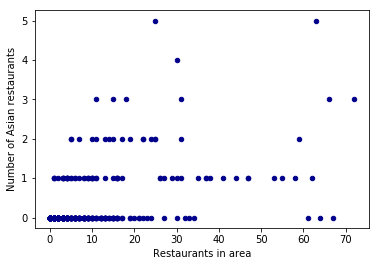

In [49]:
ax1 = df_locations.plot.scatter(x='Restaurants in area',y='Number of Asian restaurants',c='DarkBlue')

In [26]:
df_best = df_locations[(df_locations['Restaurants in area'] > 60) & (df_locations['Number of Asian restaurants'] == 0)]
df_best.head()

,Latitude,Longitude,X,Y,Distance from center,Restaurants in area,Number of Asian restaurants
155,43.663323,-79.375069,-5.309075e+06,1.050634e+07,6296.835410,64,0
173,43.705620,-79.396526,-5.302075e+06,1.050807e+07,5908.397163,61,0
199,43.665953,-79.420470,-5.308075e+06,1.051154e+07,9870.521706,67,0


In [46]:
map_toronto = folium.Map(location=MAP_COORDINATES, zoom_start=11)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_asian = res[6]
    color = 'red' if is_asian else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_toronto)

for lat,lon in zip(df_best.Latitude,df_best.Longitude):
    folium.Circle([lat, lon], radius=distance_of_centers/2/2*math.sqrt(3)*yard_to_meter, color='yellow', fill=True, fill_color='yellow',fill_opacity=0.5).add_to(map_toronto)
    
map_toronto

In [42]:
for lat,lon in zip(df_best.Latitude,df_best.Longitude):
    print(lat,lon)

43.66332320767237 -79.3750693869152
43.70562026817557 -79.39652604879593
43.665952555634846 -79.42046980907696
